Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [156]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from matplotlib.colors import ListedColormap


In [157]:
batch_size = 256
learning_rate = 0.001
num_epochs = 50
latent_dim = 32

mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 10

prefix = f"fuzzy_fuzzy_svdd"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
binary_cmap = ListedColormap(['yellow', 'red'], N=2)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [158]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(15, fill=0), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [159]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [160]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [161]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

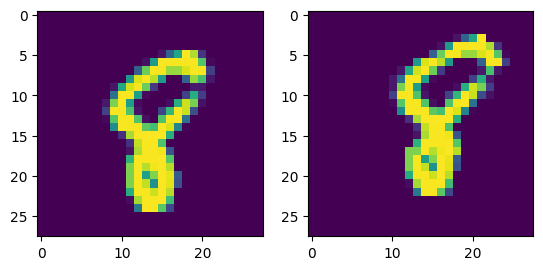

In [162]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    break

## Модель

In [163]:
class SVDD(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels, fuzzy_rules_count):
        super(SVDD, self).__init__()
                
        self.latent = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size=5, padding=2, bias=False), 
            nn.BatchNorm2d(kernels, eps=1e-04, affine=False), 
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(kernels, kernels // 2, kernel_size=5, padding=2, bias=False), 
            nn.BatchNorm2d(kernels // 2, eps=1e-04, affine=False), 
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(kernels*7*7//2, latent_dim, bias=False)
        )

        rscale = 1
        initial_centroids = 2 * rscale * (0.5- np.random.random((fuzzy_rules_count, latent_dim)))
        initial_scales = rscale * np.ones((fuzzy_rules_count, latent_dim))
        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales, trainable=True)
        )
        self.c = nn.Parameter(torch.rand(latent_dim), requires_grad = False)
        

         
    def forward(self, x):
        out = self.latent(x)
        fz = self.fuzzy(out)
        return out, (1-fz.max(-1).values)#(self.c-out).square().sum(-1)

inp = torch.rand(10, 1, 28, 28)
m = SVDD(latent_dim= latent_dim, kernels=8, fuzzy_rules_count=fuzzy_rules_count)
mu, fz = m.forward(inp)
mu.shape

torch.Size([10, 32])

In [164]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dim, kernels, fuzzy_rules_count):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, (kernels//2) *7 *7),
            nn.Unflatten(1, (kernels//2, 7, 7)),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(kernels//2, 4, 5, bias=False, padding=5),
            nn.BatchNorm2d(4, eps=1e-04, affine=False),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(4, 8, 5, bias=False, padding=3),
            nn.BatchNorm2d(8, eps=1e-04, affine=False),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(8, 1, 5, bias=False, padding=2),
            nn.Sigmoid()
        )


         
    def forward(self, x):
        out = self.decoder(x)
        return out

inp = torch.rand(10, latent_dim)
m = Decoder(latent_dim= latent_dim, kernels=8, fuzzy_rules_count=fuzzy_rules_count)
mu = m.forward(inp)
mu.shape

torch.Size([10, 1, 28, 28])

In [165]:
class ModelSVDDAE(nn.Module):
    
    def __init__(self, latent_dim, kernels, fuzzy_rules_count):
        super(ModelSVDDAE, self).__init__()                
        self.ad = SVDD(latent_dim= latent_dim, kernels=kernels, fuzzy_rules_count=fuzzy_rules_count)
        self.decoder = Decoder(latent_dim= latent_dim, kernels=kernels, fuzzy_rules_count=fuzzy_rules_count)

    def forward(self, x):
        mu, d = self.ad(x)
        x_rec = self.decoder(mu)
        return mu, d, x_rec
    
    def half_pass(self, x):
        mu, d = self.ad(x)
        return mu, d

inp = torch.rand(10, 1, 28, 28)
m = ModelSVDDAE(latent_dim= latent_dim, kernels=8, fuzzy_rules_count=fuzzy_rules_count)
mu,_,_ = m.forward(inp)
mu.shape

torch.Size([10, 32])

## Обучение

In [166]:
model = ModelSVDDAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 20,740


ModelSVDDAE(
  (ad): SVDD(
    (latent): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(8, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (5): BatchNorm2d(4, eps=0.0001, momentum=0.1, affine=False, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=196, out_features=32, bias=False)
    )
    (fuzzy): Sequential(
      (0): FuzzyLayer(
        (rots): ParameterList(
            (0): Parameter containing: [torch.float32 of size 10x31 (cuda:0)]
            (1): Parameter containing: [torch.float32 of size 

In [167]:
def get_arate(inp):
    _, d = model.half_pass(inp)
    return d.cpu().numpy()

In [168]:
def init_center_c(data_loader, net, eps=0.1):
        """Initialize hypersphere center c as the mean from an initial forward pass on the data."""
        n_samples = 0
        c = torch.zeros(latent_dim).to(device)

        net.eval()
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(tqdm(data_loader, disable=True)):
                inputs = inputs.to(device)
                mu, _ = net.half_pass(inputs)
                n_samples += mu.shape[0]
                c += torch.sum(mu, dim=0)

        c /= n_samples

        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps

        return c

init_center_c(train_loader, model)

tensor([-0.1000,  0.1034,  0.1009, -0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
        -0.1000, -0.1000,  0.1000,  0.1000, -0.1000,  0.1000, -0.1000,  0.1000,
        -0.1000,  0.1000, -0.1000,  0.1000, -0.1000,  0.1000,  0.1000, -0.1000,
         0.1000, -0.1000, -0.1000,  0.1000, -0.1000,  0.1000,  0.1000,  0.1000],
       device='cuda:0')

In [169]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train_ad(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        #adata = augmentation(data)
        
        optimizer.zero_grad()  

        x, d = model.half_pass(data)  
        
        loss = d.mean()
    
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)    
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FSVDD/LR', get_lr(optimizer), global_step=epoch)
        writer.add_scalar('FSVDD/Train/Loss/Dist', loss.item(), global_step=prev_updates)

    return prev_updates + len(dataloader)

def train_ae(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  

        _, _, x_rec = model.forward(data)  
                
        loss = (x_rec - data).square().sum(-1).sum(-1).mean()
    
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.12)    
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FSVDD/LR', get_lr(optimizer), global_step=epoch)
        writer.add_scalar('FSVDD/Train/Loss/Reconstruction', loss.item(), global_step=prev_updates)
        
    return prev_updates + len(dataloader)

In [170]:
def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    test_fz_loss = 0
    test_rec_loss = 0
    
    lab_true = []
    lab_pred = []
    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)
            
            mu, d, x_rec = model.forward(data)  
        
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            test_fz_loss += d.mean().item()
            test_rec_loss += (x_rec - data).square().sum(-1).sum(-1).mean().item()

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    centroid = model.ad.c.detach().cpu().numpy()
    ax[0].scatter(embedings[:, 0],  embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=4)
    ax[0].scatter(centroid[0],      centroid[1], marker='1', c='green', s= 50)
    ax[1].scatter(embedings[:, 0],  embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=4)
    ax[1].scatter(centroid[0],      centroid[2], marker='1', c='green', s= 50)
    
    test_fz_loss /= len(dataloader)
    test_rec_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: AUC {roc_auc:.4f} Dist {test_fz_loss:.4f} AE {test_rec_loss:4f}')
    
    if writer is not None:
        writer.add_figure('FAD/Emedding', fig, global_step=cur_step)
        writer.add_scalar('FSVDD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FSVDD/Test/Loss/Dist', test_fz_loss, global_step=cur_step)
        writer.add_scalar('FSVDD/Test/Loss/Reconstruction', test_rec_loss, global_step=cur_step)
        

In [171]:
#model.fuzzy[0].get_transformation_matrix_eigenvals()

In [172]:
prev_updates = 0

In [173]:
#optimizer = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=learning_rate)
#optimizer_d = torch.optim.Adam(model.delta_decoder.parameters(), lr=learning_rate)
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, step_size=50, gamma=0.5)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [174]:
for epoch in range(num_epochs):
    prev_updates = train_ae(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[212] Reconstruction loss: AUC 0.2853 Dist 0.9871 AE 102.941458
[424] Reconstruction loss: AUC 0.3156 Dist 0.9948 AE 50.149740
[636] Reconstruction loss: AUC 0.3507 Dist 0.9961 AE 27.994536
[848] Reconstruction loss: AUC 0.3466 Dist 0.9966 AE 20.462058
[1060] Reconstruction loss: AUC 0.3402 Dist 0.9970 AE 16.858229
[1272] Reconstruction loss: AUC 0.3479 Dist 0.9974 AE 14.944850
[1484] Reconstruction loss: AUC 0.3576 Dist 0.9976 AE 13.455230
[1696] Reconstruction loss: AUC 0.3645 Dist 0.9978 AE 12.433063
[1908] Reconstruction loss: AUC 0.3644 Dist 0.9977 AE 11.753426
[2120] Reconstruction loss: AUC 0.3641 Dist 0.9978 AE 11.264930
[2332] Reconstruction loss: AUC 0.3633 Dist 0.9978 AE 10.818006
[2544] Reconstruction loss: AUC 0.3694 Dist 0.9979 AE 10.093980
[2756] Reconstruction loss: AUC 0.3641 Dist 0.9978 AE 10.101482
[2968] Reconstruction loss: AUC 0.3620 Dist 0.9978 AE 9.301263
[3180] Reconstruction loss: AUC 0.3647 Dist 0.9978 AE 9.148632
[3392] Reconstruction loss: AUC 0.3658 Dist 0

In [175]:
new_c = init_center_c(train_loader, model)
model.ad.c = nn.Parameter(new_c, requires_grad = False)
model.ad.c

Parameter containing:
tensor([-0.1000,  2.0131,  2.3018,  0.3000, -0.1124,  0.1842, -0.3076, -0.2715,
         0.2775, -1.5451,  1.3606,  1.8876,  0.1000, -0.5996, -1.2722, -0.5050,
         0.1596,  0.5640, -0.4143, -0.9693, -2.0439,  1.5290,  0.1767,  0.8349,
         0.1602, -0.3646, -1.0024,  0.3407, -0.5879, -0.1633,  0.1000,  0.7280],
       device='cuda:0')

In [176]:
learning_rate = 1e-5
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
#scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))

In [ ]:
for epoch in range(num_epochs):
    prev_updates = train_ad(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)

[10812] Reconstruction loss: AUC 0.4082 Dist 0.9973 AE 6.082503
[11024] Reconstruction loss: AUC 0.4061 Dist 0.9971 AE 6.198285
[11236] Reconstruction loss: AUC 0.4040 Dist 0.9969 AE 6.372281
[11448] Reconstruction loss: AUC 0.4018 Dist 0.9967 AE 6.670459
[11660] Reconstruction loss: AUC 0.3996 Dist 0.9965 AE 7.154490
[11872] Reconstruction loss: AUC 0.3962 Dist 0.9961 AE 7.927808
[12084] Reconstruction loss: AUC 0.3925 Dist 0.9957 AE 9.083623
[12296] Reconstruction loss: AUC 0.3880 Dist 0.9952 AE 10.594716
[12508] Reconstruction loss: AUC 0.3839 Dist 0.9945 AE 12.834935
[12720] Reconstruction loss: AUC 0.3789 Dist 0.9935 AE 15.787922
[12932] Reconstruction loss: AUC 0.3731 Dist 0.9923 AE 19.701592
[13144] Reconstruction loss: AUC 0.3670 Dist 0.9906 AE 24.621229
[13356] Reconstruction loss: AUC 0.3603 Dist 0.9882 AE 30.767596
[13568] Reconstruction loss: AUC 0.3537 Dist 0.9852 AE 37.390669
[13780] Reconstruction loss: AUC 0.3479 Dist 0.9815 AE 43.831297
[13992] Reconstruction loss: AUC

In [ ]:
#model.fuzzy[0].get_transformation_matrix_eigenvals()

In [ ]:
#keep_eigenvals_positive_loss(model.fuzzy[0])

## Визуализируем результаты

In [ ]:
def get_arate(inp):
    mu, fz = model.half_pass(inp)

    return fz.cpu().numpy() #(1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# (1 - ssim((x_recon + 1)/2, (inp + 1)/2)).cpu().numpy() #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

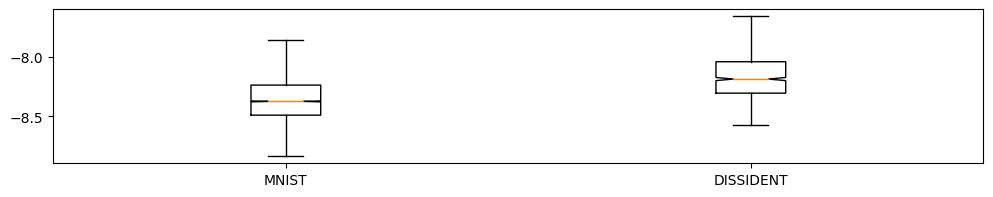

In [ ]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

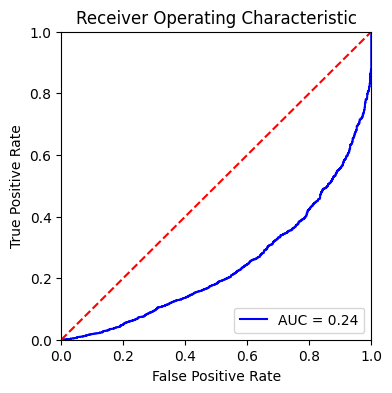

In [ ]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(0)
            else:
                lab_true.append(1)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)